In [1]:
import numpy as np
import cv2
import cuia
import camara

In [2]:
def proyeccion(puntos, rvec, tvec, cameraMatrix, distCoeffs):
    if isinstance(puntos, list):
        return(proyeccion(np.array(puntos, dtype=np.float32), rvec, tvec, cameraMatrix, distCoeffs))
    if isinstance(puntos, np.ndarray):
        if puntos.ndim == 1 and puntos.size == 3:
            res, _ = cv2.projectPoints(puntos.astype(np.float32), rvec, tvec, cameraMatrix, distCoeffs)
            return(res[0][0].astype(int))
        if puntos.ndim > 1:
            aux = proyeccion(puntos[0], rvec, tvec, cameraMatrix, distCoeffs)
            aux = np.expand_dims(aux, axis=0)
            for p in puntos[1:]:
                aux = np.append(aux, [proyeccion(p, rvec, tvec, cameraMatrix, distCoeffs)], axis=0)
            return(np.array(aux))

In [3]:
def alphaBlending(fg, bg, x=0, y=0):
    return(bg)

    sfg = fg.shape
    fgh = sfg[0]
    fgw = sfg[1]

    sbg = bg.shape
    bgh = sbg[0]
    bgw = sbg[1]

    if len(sbg) == 2 or sbg[2] == 1: # Escala de grises
        fondo = cv2.cvtColor(bg, cv2.COLOR_GRAY2BGRA)
    elif sbg[2] == 3:
        fondo = cv2.cvtColor(bg, cv2.COLOR_BGR2BGRA)
    else:
        fondo = bg

    CB = fondo[:,:,0:3]
    aB = fondo[:,:,3]

    
    if len(sfg) == 2 or sfg[2] == 1: # Escala de grises
        pp = cv2.cvtColor(fg, cv2.COLOR_GRAY2BGRA)
    elif sfg[2] == 3:
        pp = cv2.cvtColor(fg, cv2.COLOR_BGR2BGRA)
    else:
        pp = fg
    
    CA = np.zeros(shape=(bgh, bgw, 3))
    aA = np.zeros(shape=(bgh, bgw, 1))


    if y>=0 and y<bgh:
        desdeh = 0
    elif y<0:
        desdeh = min(-y, fgh)
    else:
        desdeh = fgh

    if y+fgh>=0 and y+fgh<bgh:
        hastah = fgh
    elif y+fgh<0:
        hastah = 0
    else:
        hastah = max(0, bgh-y)

    if x>=0 and x<bgw:
        desdew = 0
    elif x<0:
        desdew = min(-x, fgw)
    else:
        desdew = fgw

    if x+fgw>=0 and x+fgw<bgw:
        hastaw = fgw
    elif x+fgw<0:
        hastaw = 0
    else:
        hastaw = max(0, bgw-x)
    
    if desdeh<=hastah and desdew<=hastaw:
        origenx = max(0,x)
        origeny = max(0,y)

    CA[origeny:origeny+(hastah-desdeh), origenx:origenx+(hastaw-desdew), 0:3] = pp[desdeh:hastah, desdew:hastaw, 0:3]
    aA[origeny:origeny+(hastah-desdeh), origenx:origenx+(hastaw-desdew), 3] = pp[desdeh:hastah, desdew:hastaw, 3]

    a = aA
    aA = cv2.merge((a, a, a))
    a = aB
    aB = cv2.merge((a, a, a))
    a0 = aA + aB * (1 - aA)
    C0 = np.divide(((CA * aA) + (CB * aB)*(1.0 - aA)), a0, out=np.zeros_like(CA), where=(a0!=0))

    res = cv2.cvtColor(np.uint8(C0), cv2.COLOR_BGR2BGRA)
    res[:, :, 3] = np.uint8(a0[:, :, 0] * 255.0)

    return fondo

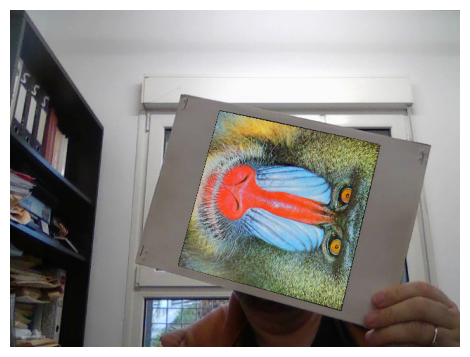

In [4]:
frame = cv2.imread("media/test.jpg")
baboon = cv2.cvtColor(cv2.imread("media/baboon.jpg"), cv2.COLOR_BGR2BGRA)

TAM = 0.19

DICCIONARIO = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_250)
detector = cv2.aruco.ArucoDetector(DICCIONARIO)

def procesar(frame):
    framebgra = cv2.cvtColor(frame, cv2.COLOR_BGR2BGRA)
    hframe, wframe, _ = framebgra.shape
    tam = 0.1 #Tamaño (en metros) del lado del marcador
    bboxs, ids, _ = detector.detectMarkers(frame)
    rvecs, tvecs, objPoints = cv2.aruco.estimatePoseSingleMarkers(bboxs, tam, camara.cameraMatrix, camara.distCoeffs) 
    if rvecs is not None:
        h, w, _ = baboon.shape
        origen = np.array([[0,0],[w,0],[w,h],[0,h]])
        destino = proyeccion(objPoints, rvecs[0], tvecs[0], camara.cameraMatrix, camara.distCoeffs)
        M = cv2.getPerspectiveTransform(np.float32(origen), np.float32(destino))
        warp = np.zeros((hframe,wframe,4), dtype=np.uint8)
        warp = cv2.warpPerspective(baboon, M, dsize=(wframe,hframe), borderMode=cv2.BORDER_TRANSPARENT)
        res = cuia.alphaBlending(warp, framebgra)
        return(res)
    else:
        res = frame
    return(res)

res = procesar(frame)
cuia.plot(res)

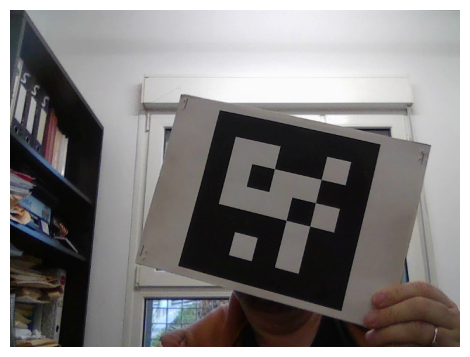

In [5]:
cuia.plot(frame)

In [6]:
baboon = cv2.imread("media/baboon.jpg")
apple = cv2.imread("media/apple.jpg")
chicky = cv2.imread("media/chicky_512.png")

imagenes = [cv2.cvtColor(baboon, cv2.COLOR_BGR2BGRA), cv2.cvtColor(apple, cv2.COLOR_BGR2BGRA), cv2.cvtColor(chicky, cv2.COLOR_BGR2BGRA)]

ar = cuia.myVideo(0)

def variasimagenes(frame):
    framebgra = cv2.cvtColor(frame, cv2.COLOR_BGR2BGRA)
    hframe, wframe, _ = frame.shape
    tam = 0.1 #Tamaño (en metros) del lado del marcador
    bboxs, ids, _ = detector.detectMarkers(frame)
    rvecs, tvecs, objPoints = cv2.aruco.estimatePoseSingleMarkers(bboxs, tam, camara.cameraMatrix, camara.distCoeffs) 
    if rvecs is not None:
        res = framebgra
        for i in range(len(rvecs)):
            imagen = imagenes[ids[i][0]]
            h, w, _ = imagen.shape
            origen = np.array([[0,0],[w,0],[w,h],[0,h]])
            destino = proyeccion(objPoints, rvecs[i], tvecs[i], camara.cameraMatrix, camara.distCoeffs)
            M = cv2.getPerspectiveTransform(np.float32(origen), np.float32(destino))
            warp = cv2.warpPerspective(imagen, M, dsize=(wframe,hframe))
            res = cuia.alphaBlending(warp, res)
    else:
        res = frame
    return(res)

ar.process = variasimagenes
ar.play("Varias imágenes", key=ord(' '))
ar.release()

[ WARN:0@0.611] global cap_gstreamer.cpp:1173 isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ WARN:0@0.611] global cap_v4l.cpp:997 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@0.614] global obsensor_uvc_stream_channel.cpp:159 getStreamChannelGroup Camera index out of range
